In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

2024-03-03 20:59:53.877659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define notebook constants
DATASET_FILEPATH = "./dataset/mc-chic1.csv"

# **Exercise 1**

## **Loading in dataset & data exploration**

In [3]:
# Parse and read csv as a dataframe
dataframe = pd.read_csv(DATASET_FILEPATH, delimiter=",", header=0, index_col=0)
# Print out head of our dataframe to performa a sanity check
dataframe.head(10)

,ep,eta,p,phi,pol,pt,qp,tx,ty,zV
0,0.005459,3.210803,72.079880,0.294754,1.0,5.803692,72.079880,0.077296,0.023467,-60.3975
1,0.004050,4.436362,37.638340,-0.088796,1.0,0.891071,-37.638340,0.023588,-0.002100,-60.3975
2,0.003901,3.577396,18.565832,0.319936,1.0,1.036960,18.565832,0.053102,0.017594,-60.3975
3,0.003859,3.532860,8.632520,0.219504,1.0,0.504075,-8.632520,0.057089,0.012736,-60.3975
4,0.004975,3.300828,43.359665,-0.720869,1.0,3.191501,43.359665,0.055445,-0.048714,-8.0373
5,0.004481,4.217176,66.163826,0.097564,1.0,1.950114,-66.163826,0.029347,0.002872,-8.0373
6,0.005919,3.916690,8.657219,-0.134673,1.0,0.344540,8.657219,0.039469,-0.005348,-8.0373
7,0.003588,3.434997,4.931572,0.270846,1.0,0.317515,-4.931572,0.062166,0.017262,-8.0373
8,0.004865,3.561846,39.078457,1.871018,1.0,2.216805,39.078457,-0.016803,0.054277,-81.6274
9,0.006025,3.624830,104.407350,0.962990,1.0,5.561719,-104.407350,0.030464,0.043791,-81.6274


In [4]:
# Print out number of NANs in each column
print(f"{'#'*5} NUMBER OF NANs {'#'*5}")
print(dataframe.isna().sum())
print("\n")

# Check the values of polarity to cvheck if they are integer numbers
print(f"{'#'*5} POLARITY VALUES {'#'*5}")
print(np.unique(dataframe["pol"]))
print("\n")

# Print our a description of our dataframe to continue sanity check
print(f"{'#'*5} DATAFRAME DESCRIPTION {'#'*5}")
dataframe.describe()

##### NUMBER OF NANs #####
ep     0
eta    0
p      0
phi    0
pol    0
pt     0
qp     0
tx     0
ty     0
zV     0
dtype: int64


##### POLARITY VALUES #####
[-1.  1.]


##### DATAFRAME DESCRIPTION #####


,ep,eta,p,phi,pol,pt,qp,tx,ty,zV
count,208984.000000,208984.000000,208984.000000,208984.000000,208984.000000,208984.000000,208984.000000,208984.000000,208984.000000,208984.000000
mean,0.004582,3.536235,38.009716,0.020532,-0.013015,2.057444,-0.057122,-0.000804,0.000338,-3.537095
std,0.001043,0.535136,46.989681,1.781738,0.999918,2.188101,60.438169,0.050532,0.058026,40.933908
min,0.002469,1.817449,2.984704,-3.140953,-1.000000,0.182415,-1121.218000,-0.261077,-0.260077,-177.157300
25%,0.003846,3.153929,8.014261,-1.572803,-1.000000,0.466294,-18.415584,-0.032667,-0.038117,-30.886000
50%,0.004337,3.530497,18.407946,0.087080,-1.000000,1.100179,-0.000750,-0.000798,0.002586,-3.441400
75%,0.005027,3.922414,51.289614,1.601350,1.000000,3.103085,18.401911,0.031472,0.038615,23.986100
max,0.029343,5.096044,1121.218000,3.141593,1.000000,33.016370,846.472400,0.290477,0.258590,162.495500


As we can see from above, there are no NANs in the dataframe and each column contains the same number of counts.

We also see that the ranges for the datapoints in each column are realistic, with the angular data ranging from [$-\pi$, $\pi$], contunous data ranging from beliavable values and polarity ranging from the interger values -1 and 1.

Below we look to reproduce the plot from figure 1 in the lecture notes

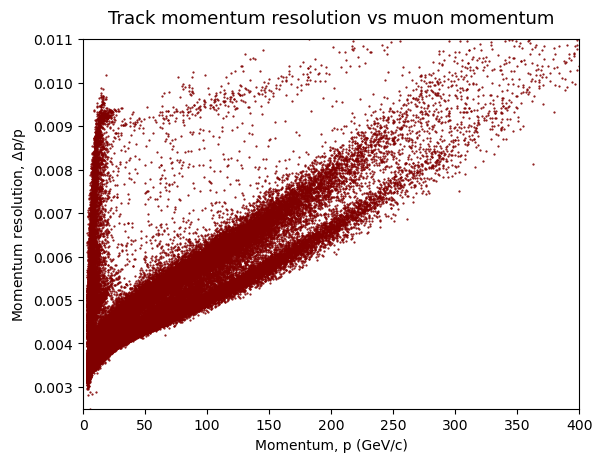

In [5]:
# Define limits of plot 
x_limit = (0, 400)
y_limit = (2.5e-3, 1.1e-2)

# Plot resolution track momentum resolution as function of momentum
plt.scatter(dataframe["p"], dataframe["ep"], s=0.3, c="maroon")
plt.xlabel("Momentum, p (GeV/c)")
plt.ylabel(r"Momentum resolution, $\Delta$p/p")
plt.title("Track momentum resolution vs muon momentum", y=1.02, fontsize=13)
plt.xlim(x_limit)
_=plt.ylim(y_limit)

# **Exercise 2**

## **Demonstrating $p_T << p_z$**

We first create numpy array containing the variables we look to append later to the dataframe

In [6]:
# Calcutale the z component of momentum
pz = np.sqrt(dataframe["p"]**2 - dataframe["pt"]**2)

# Calculate the error for the z component of the momentum for the muon trakc fit
epz = dataframe["ep"] * (dataframe["p"] / pz)

# Check there are no nans in the calculated data
print(f"Does pz contain NaNs?:    {np.any(np.isnan(pz))}")
print(f"Does epz contain NaNs?:   {np.any(np.isnan(epz))}\n")

# Append both variables to dataframe
dataframe["pz"] = pz
dataframe["epz"] = epz

# Print out head to check variables were appended 
dataframe.head(10)

Does pz contain NaNs?:    False
Does epz contain NaNs?:   False



,ep,eta,p,phi,pol,pt,qp,tx,ty,zV,pz,epz
0,0.005459,3.210803,72.079880,0.294754,1.0,5.803692,72.079880,0.077296,0.023467,-60.3975,71.845851,0.005477
1,0.004050,4.436362,37.638340,-0.088796,1.0,0.891071,-37.638340,0.023588,-0.002100,-60.3975,37.627791,0.004052
2,0.003901,3.577396,18.565832,0.319936,1.0,1.036960,18.565832,0.053102,0.017594,-60.3975,18.536851,0.003908
3,0.003859,3.532860,8.632520,0.219504,1.0,0.504075,-8.632520,0.057089,0.012736,-60.3975,8.617790,0.003866
4,0.004975,3.300828,43.359665,-0.720869,1.0,3.191501,43.359665,0.055445,-0.048714,-8.0373,43.242050,0.004989
5,0.004481,4.217176,66.163826,0.097564,1.0,1.950114,-66.163826,0.029347,0.002872,-8.0373,66.135081,0.004483
6,0.005919,3.916690,8.657219,-0.134673,1.0,0.344540,8.657219,0.039469,-0.005348,-8.0373,8.650360,0.005923
7,0.003588,3.434997,4.931572,0.270846,1.0,0.317515,-4.931572,0.062166,0.017262,-8.0373,4.921340,0.003595
8,0.004865,3.561846,39.078457,1.871018,1.0,2.216805,39.078457,-0.016803,0.054277,-81.6274,39.015530,0.004873
9,0.006025,3.624830,104.407350,0.962990,1.0,5.561719,-104.407350,0.030464,0.043791,-81.6274,104.259110,0.006034


We now create the plots which are requested by the lecture notes

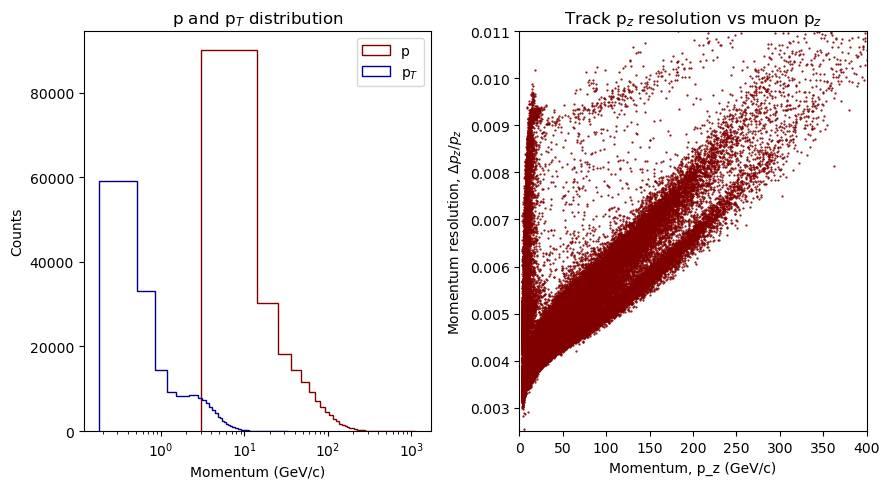

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))

# Plot the pt and p 1d distributions
ax1.hist(dataframe["p"], 100, color="maroon", label="p", histtype="step")
ax1.hist(dataframe["pt"], 100, color="darkblue", label=r"p$_T$", histtype="step")
ax1.set(
    ylabel = "Counts",
    xlabel = "Momentum (GeV/c)",
    xscale = "log",
    title = r"p and p$_T$ distribution"
)
ax1.legend()

# Plot the z component momentum resolution distribution
ax2.scatter(pz, epz, s=0.3, color="maroon")
ax2.set(
    xlabel = r"Momentum, p_z (GeV/c)",
    ylabel = r"Momentum resolution, $\Delta p_z$/$p_z$",
    title = r"Track p$_z$ resolution vs muon p$_z$",
    xlim = x_limit,
    ylim = y_limit
)
fig.tight_layout()

From the plots above, we can easily see that the value of the $p_T$ parameters are $~ \mathcal{O}(10)$ smaller than the value of the momentum parameters.

Similarly, we see that the distribution for $\frac{\Delta p_z}{p_z}$ vs $p_z$ is similar to that of $\frac{\Delta p_z}{p}$

# **Exercese 3**

## **Regression with TF networks**

We will now create multiple networks which will look to predict the **$\frac{\Delta p}{p}$** using the following features as an input: **p, tx, ty, eta, phi**

Now we create a simple dense neural network with no hidden layers:

In [8]:
def build_simple_dense(input_features=5, output_features=1, loss="mean_squared_error", optimizer="adam"):
    """
    Create a simple two layer dense neural network w/ no hidden layers
    """
    # Create network
    network = tf.keras.models.Sequential([
        tf.keras.layers.Dense(input_features, input_dim=input_features, kernel_initializer="normal"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(output_features, kernel_initializer="normal"),
    ])

    # Compile and return network
    network.compile(loss=loss, optimizer=optimizer)

    return network

# Define network parameters
input_features  = 5
output_features = 1
epochs          = 100
batch_size      = 1024
seed            = 42
mean            = 0.0
std             = 0.3

# Set seed for reproducibility
np.random.seed(seed)

We will start by creating out input data and target numpy arrays, as well as applying some preprocessing steps to improve the network performance

In [9]:
# Define dataframe keys which will be used for input and target data
input_keys = ["p", "tx", "ty", "eta", "phi"]
target_keys = ["ep"]

# Generate input and target arrays
input_data = dataframe[input_keys].to_numpy()
target_data = dataframe[target_keys].to_numpy()

# Check data array shapes
print(f"Input data:     {input_data.shape}")
print(f"Target data:    {target_data.shape}")

# Make dictionary to contain r2 scores for different models
r2_scores = {}

Input data:     (208984, 5)
Target data:    (208984, 1)


We now train the simple dense network to predict the $\frac{\Delta p_z}{p_z}$ for each track

In [10]:
# Write the regression algorithem using simple neural network
estimator = KerasRegressor(
    build_fn = build_simple_dense,
    epochs = epochs,
    batch_size = batch_size, 
    verbose = 0
)
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(estimator, input_data, target_data, cv=kfold, scoring="r2")

# Print results of training
print("\nNon-Standardized: %.2f %s %.2f" % (results.mean(), u"\u00B1", results.std()))

# Add r2 scores 
r2_scores["non_standard"] = [results.mean(), results.std()]

/tmp/ipykernel_31182/2201232988.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(
2024-03-03 20:59:55.969239: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.



Non-Standardized: 0.72 ± 0.01


I found that I can use a batch size of 1024 with 100 epochs to achieve an initial r2 score of $0.72\pm 0.01$ 

Now we create a pipeline in order to inclide data standardadasion

In [11]:
# Create pipeline
pipeline = Pipeline([
    ("standardise", StandardScaler()),
    ("mpl", KerasRegressor(build_fn=build_simple_dense, epochs=epochs, batch_size=batch_size, verbose=0)),
])

# Utilise pipeline and compute cross validation score
results = cross_val_score(pipeline, input_data, target_data, cv=kfold, scoring="r2")

# Print results of training
print("\nStandardized: %.2f %s %.2f" % (results.mean(), u"\u00B1", results.std()))

# Add r2 scores 
r2_scores["standard"] = [results.mean(), results.std()]

/tmp/ipykernel_31182/2328612622.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ("mpl", KerasRegressor(build_fn=build_simple_dense, epochs=epochs, batch_size=batch_size, verbose=0)),



Standardized: 0.72 ± 0.01


We now create a deep dense network with 1 hidden layer with 3 nodes

In [12]:
def build_deep_dense(input_features=5, hidden_features=3, output_features=1, loss="mean_squared_error", optimizer="adam"):
    """
    Create a simple two layer dense neural network w/ no hidden layers
    """
    # Create network
    network = tf.keras.models.Sequential([
        tf.keras.Input(shape=(input_features)),
        tf.keras.layers.Dense(hidden_features,kernel_initializer="normal"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(output_features, kernel_initializer="normal"),
    ])

    # Compile and return network
    network.compile(loss=loss, optimizer=optimizer)

    return network



# Create pipeline
pipeline = Pipeline([
    ("standardise", StandardScaler()),
    ("mpl", KerasRegressor(build_fn=build_deep_dense, epochs=epochs, batch_size=batch_size, verbose=0)),
])

# Utilise pipeline and compute cross validation score
results = cross_val_score(pipeline, input_data, target_data, cv=kfold, scoring="r2")

# Print results of training
print("\nDeep: %.2f %s %.2f" % (results.mean(), u"\u00B1", results.std()))

# Add r2 scores 
r2_scores["deep"] = [results.mean(), results.std()]

/tmp/ipykernel_31182/3608927489.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ("mpl", KerasRegressor(build_fn=build_deep_dense, epochs=epochs, batch_size=batch_size, verbose=0)),



Deep: 0.71 ± 0.02


We now create a wider model and compare results

In [13]:
def build_wide_dense(input_features=5, output_features=1, loss="mean_squared_error", optimizer="adam"):
    """
    Create a simple wide layer wide dense neural network w/ no hidden layers
    """
    # Create network
    network = tf.keras.models.Sequential([
        tf.keras.layers.Dense(input_features*2, input_dim=input_features, kernel_initializer="normal"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(output_features, kernel_initializer="normal"),
    ])

    # Compile and return network
    network.compile(loss=loss, optimizer=optimizer)

    return network

# Create pipeline
pipeline = Pipeline([
    ("standardise", StandardScaler()),
    ("mpl", KerasRegressor(build_fn=build_wide_dense, epochs=epochs, batch_size=batch_size, verbose=0)),
])

# Utilise pipeline and compute cross validation score
results = cross_val_score(pipeline, input_data, target_data, cv=kfold, scoring="r2")

# Print results of training
print("\nWide: %.2f %s %.2f" % (results.mean(), u"\u00B1", results.std()))

# Add r2 scores 
r2_scores["wide"] = [results.mean(), results.std()]

/tmp/ipykernel_31182/686297971.py:21: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ("mpl", KerasRegressor(build_fn=build_wide_dense, epochs=epochs, batch_size=batch_size, verbose=0)),



Wide: 0.73 ± 0.01


# **Exercise 4**

We will not try to create a model capable of beating the benchmark of $r^2=0.82\pm0.01$

The execution of the cell below takes $\sim 20$ minutes on my computer.

In [14]:
def build_improved_dense(input_features=7, output_features=1, loss="mean_squared_error", optimizer="adam"):
    """
    Create a simple wide layer wide dense neural network w/ no hidden layers
    """
    # Create network
    network = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, input_dim=input_features, kernel_initializer="normal"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(16, kernel_initializer="normal"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(8, kernel_initializer="normal"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(4, kernel_initializer="normal"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(output_features, kernel_initializer="normal"),
    ])

    # Compile and return network
    network.compile(loss=loss, optimizer=optimizer)

    return network

# Create pipeline
pipeline = Pipeline([
    ("standardise", StandardScaler()),
    ("mpl", KerasRegressor(build_fn=build_improved_dense, epochs=epochs, batch_size=batch_size, verbose=0)),
])

# Define dataframe keys which will be used for input and target data
input_keys = ["p", "tx", "ty", "eta", "phi", "pt", "qp"]

# Generate input and target arrays
input_data = dataframe[input_keys].to_numpy()

# Utilise pipeline and compute cross validation score
results = cross_val_score(pipeline, input_data, target_data, cv=kfold, scoring="r2")

# Print results of training
print("\nImproved: %.2f %s %.2f" % (results.mean(), u"\u00B1", results.std()))

# Add r2 scores 
r2_scores["Benchmark"] = [0.81, 0.01]
r2_scores["Improved"] = [results.mean(), results.std()]

/tmp/ipykernel_31182/2388776375.py:26: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ("mpl", KerasRegressor(build_fn=build_improved_dense, epochs=epochs, batch_size=batch_size, verbose=0)),



Improved: 0.84 ± 0.01


We find that the imporved model has an r2 score of $0.84 \pm 0.01$ which is an improvement over the previous best model and a slight improvement over the benchmark

We will now use our model to predict $\sigma_{p}/p$ and produce plots to visually inspect the performance of the model.

In [15]:
# Use model to predict ep
predicted_ep = cross_val_predict(pipeline, input_data, target_data, cv=kfold)

We will first produce a plot to compare the predicted ep vs the true ep.

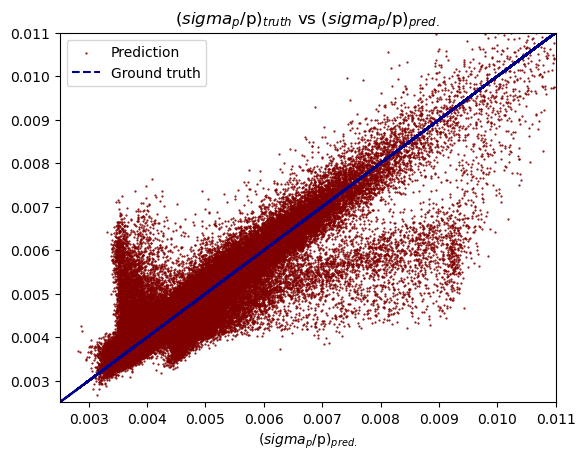

In [16]:
# Define limits of plot 
limit = (2.5e-3, 1.1e-2)

# Plot precicted ep vs true ep
plt.scatter(dataframe["ep"], predicted_ep, s=0.3, color="maroon", label="Prediction")

# Plot on overlay of x=y
plt.plot(dataframe["ep"], dataframe["ep"], ls="--", color="darkblue", label="Ground truth")

plt.xlabel(r"($sigma_{p}$/p)$_{truth}$")
plt.xlabel(r"($sigma_{p}$/p)$_{pred.}$")
plt.title(r"($sigma_{p}$/p)$_{truth}$ vs ($sigma_{p}$/p)$_{pred.}$")
plt.xlim(limit)
plt.ylim(limit)
plt.legend()

We then produce a plot where we use the predicted ep to recreate the earlier ep vs p plots

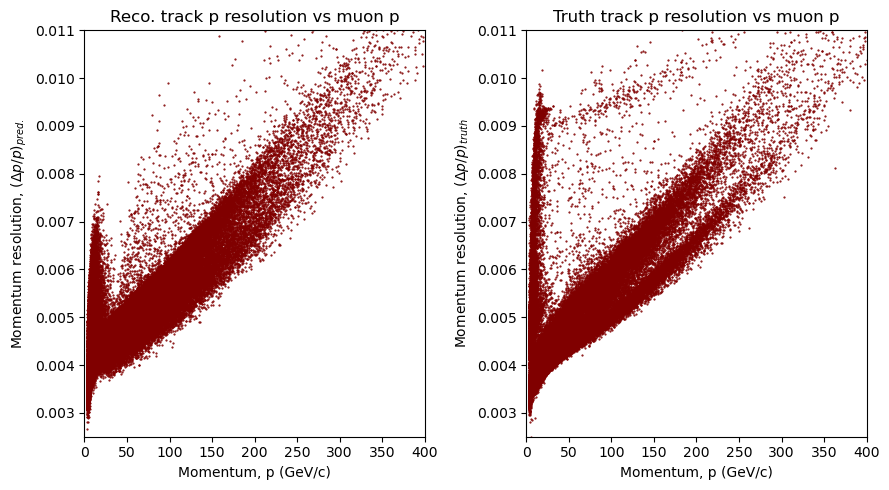

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))

# Plot the reconstricted p momentum resolution distribution
ax1.scatter(dataframe["p"], predicted_ep, s=0.3, color="maroon")
ax1.set(
    xlabel = r"Momentum, p (GeV/c)",
    ylabel = r"Momentum resolution, ($\Delta p$/$p$)$_{pred.}$",
    title = r"Reco. track p resolution vs muon p",
    xlim = x_limit,
    ylim = y_limit
)

# Plot the truth momentum resolution distribution
ax2.scatter(dataframe["p"], dataframe["ep"], s=0.3, color="maroon")
ax2.set(
    xlabel = r"Momentum, p (GeV/c)",
    ylabel = r"Momentum resolution, ($\Delta p$/$p$)$_{truth}$",
    title = r"Truth track p resolution vs muon p",
    xlim = x_limit,
    ylim = y_limit
)
fig.tight_layout()

What we see from the above plot is the fact that the regression model generally does a good job at predicting the main resolution bands (altough there is some blurring between the two main resolution bands).

We see the main struggles of the regression model is the reconstruction of the vertical band centered around $\sim 10$ GeV/c.